In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
Stopwords = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle
import re
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mahammedsabeerali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('DATA/amazon_alexa.tsv', delimiter='\t', quoting = 3)
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
print(f'data shape: {df.shape}')

data shape: (3150, 5)


In [4]:
df.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [5]:
df[df['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [6]:
df.dropna(inplace=True)

In [7]:
print(f'data shape after dropping null values: {df.shape}')

data shape after dropping null values: (3149, 5)


In [8]:
#A new column that contains the length of the each review.
df['length'] = df['verified_reviews'].apply(len)

In [9]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [10]:
print(f'verified_review: {df.iloc[11]['verified_reviews']}')
print(f'lenght of the review: {len(df.iloc[11]['verified_reviews'])}')
print(f'length column value: {df.iloc[11]['length']}')

verified_review: I love it! Learning knew things with it eveyday! Still figuring out how everything works but so far it's been easy to use and understand. She does make me laugh at times
lenght of the review: 169
length column value: 169


In [11]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3149 entries, 0 to 3149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3149 non-null   int64 
 1   date              3149 non-null   object
 2   variation         3149 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3149 non-null   int64 
 5   length            3149 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 172.2+ KB


In [13]:
df.describe()

,rating,feedback,length
count,3149.000000,3149.000000,3149.000000
mean,4.463957,0.918704,132.714513
std,1.067773,0.273332,182.541531
min,1.000000,0.000000,1.000000
25%,4.000000,1.000000,30.000000
50%,5.000000,1.000000,74.000000
75%,5.000000,1.000000,166.000000
max,5.000000,1.000000,2853.000000


In [14]:
df['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

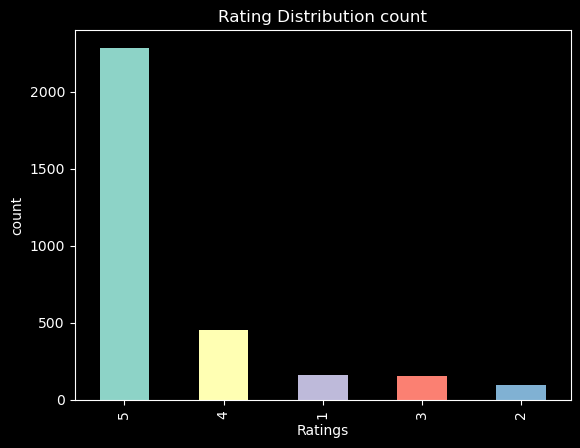

In [15]:
colors = plt.cm.Set3(range(df['rating'].nunique()))
plt.style.use('dark_background')
df['rating'].value_counts().plot.bar( color = colors)
plt.title('Rating Distribution count')
plt.xlabel('Ratings')
plt.ylabel('count')
plt.show()

In [16]:
rating_counts = df['rating'].value_counts()
rating_percent = (rating_counts / len(df)) * 100
print("Rating percentage distribution:")
print(rating_percent.round(2))

Rating percentage distribution:
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


In [17]:
df['rating'].value_counts()/df.shape[0]

rating
5    0.725945
4    0.144490
1    0.051127
3    0.048269
2    0.030168
Name: count, dtype: float64

Text(0.5, 1.0, 'Rating Distribution')

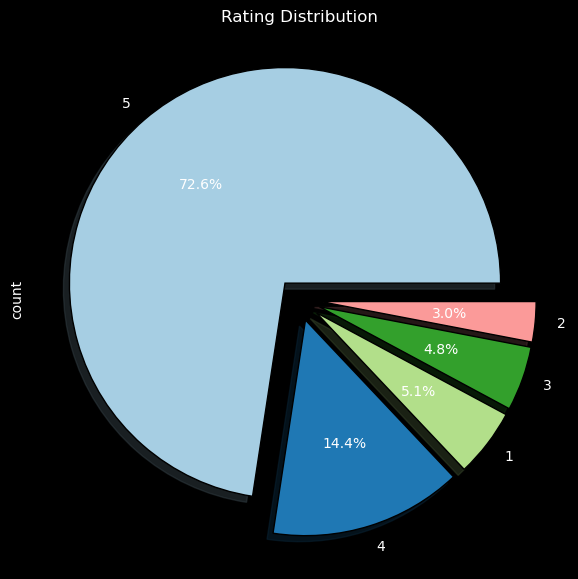

In [18]:
plt.figure(figsize=(7, 7))
colors = plt.cm.Paired(range(df['rating'].nunique()))
wp = {'linewidth': 1, 'edgecolor': 'black'}
tags = df['rating'].value_counts()/df.shape[0]
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
tags.plot(kind = 'pie', autopct = '%.1f%%', shadow = True, colors = colors, explode = explode , wedgeprops = wp)
plt.title('Rating Distribution')


In [19]:
df['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [20]:
#Extracting the negative review
df[df['feedback'] == 0].iloc[5]['verified_reviews']

'"Really disappointed Alexa has to be plug-in to wall socket all the time.  My fault for not checking this, but made the assumption that a company has technologically advanced as Amazon would sell this product with a rechargeable battery.  If I could return it, I would as my Apple music and boom speaker give me more flexibility the Alexa."'

In [21]:
#Extracting the positive review
df[df['feedback'] == 1].iloc[5]['verified_reviews']

'"I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do."'

<Axes: xlabel='feedback'>

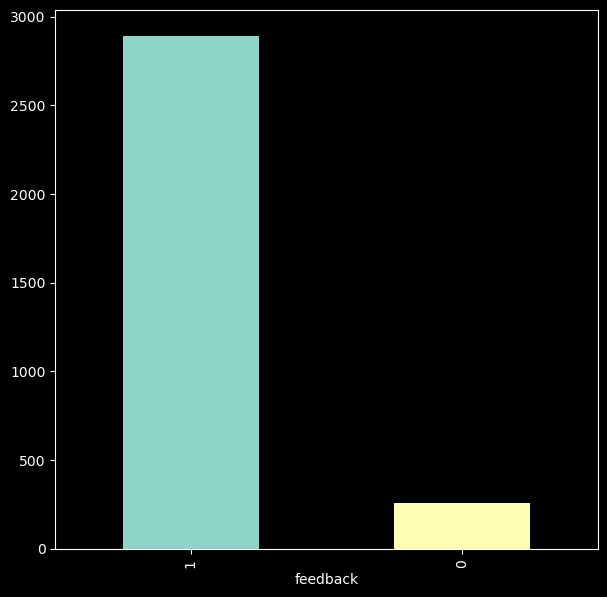

In [22]:
plt.figure(figsize=(7,7))
df['feedback'].value_counts().plot(kind = 'bar', color = plt.cm.Set3(range(df['feedback'].nunique())))

In [23]:
feedback_counts = df['feedback'].value_counts()
feedback_percent = (feedback_counts / len(df)) * 100 
print("Feedback percentage distribution:")
print(feedback_percent.round(2))

Feedback percentage distribution:
feedback
1    91.87
0     8.13
Name: count, dtype: float64


<Axes: ylabel='count'>

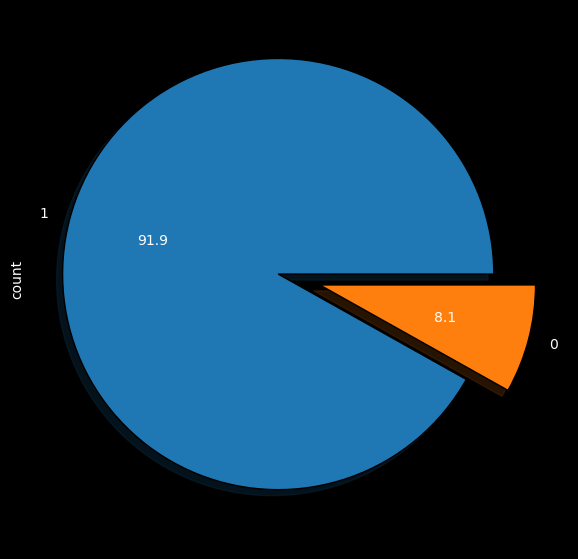

In [24]:
plt.figure(figsize = (7, 7))
colors = plt.cm.tab10(range(df[df['feedback'] == 0]['verified_reviews'].nunique()))
wp = {'linewidth': 1, 'edgecolor': 'black'}
explode = (0.1, 0.1)
tags = df['feedback'].value_counts()/len(df)
tags.plot(kind = 'pie', autopct = "%.1f", shadow = True, colors = colors, explode = explode, wedgeprops = wp)

In [25]:
df[df['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [26]:
df[df['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [27]:
#variations in the amazaon alexa
df['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

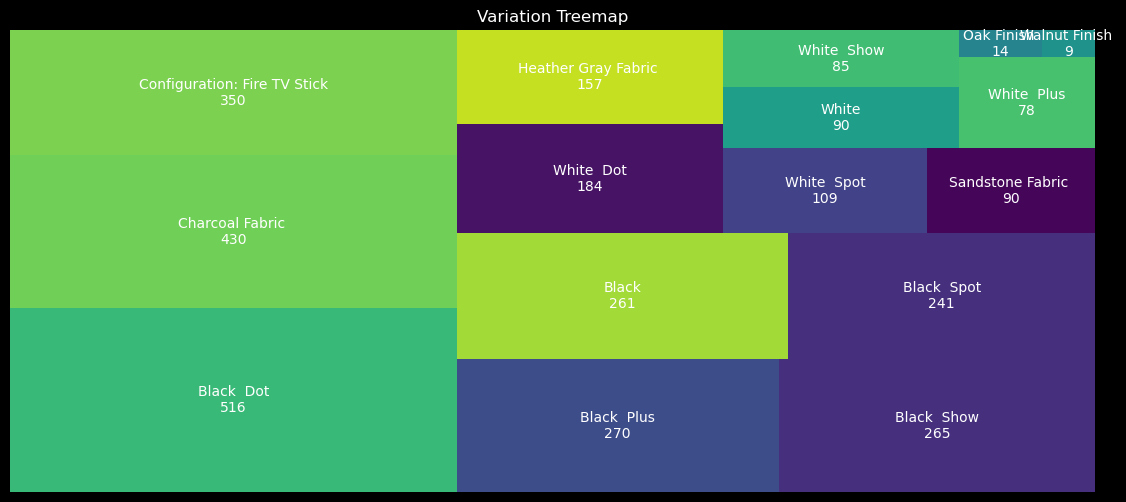

In [28]:
import matplotlib.pyplot as plt
import squarify
counts = df['variation'].value_counts()
labels = [f"{label}\n{count}" for label, count in zip(counts.index, counts.values)]
plt.style.use('dark_background')
plt.figure(figsize=(14, 6))
squarify.plot(sizes=counts.values, label=labels)
plt.axis('off')
plt.title("Variation Treemap")
plt.show()


In [29]:
variation_counts = df['variation'].value_counts()
variation_percent = (variation_counts/len(df))*100
print(f"variation percentage distribution: \n{round(variation_percent, 2)}")

variation percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [30]:
df.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

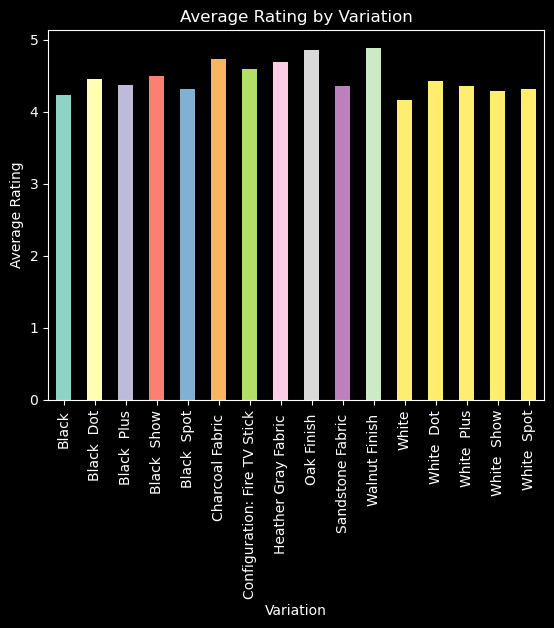

In [31]:
df.groupby('variation')['rating'].mean().plot(kind = 'bar', color = plt.cm.Set3(range(df['variation'].nunique())))
plt.title('Average Rating by Variation')
plt.xlabel('Variation')
plt.ylabel('Average Rating')
plt.show()

In [32]:
df['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

Text(0.5, 1.0, 'Distribution of Length of Positive Reviews')

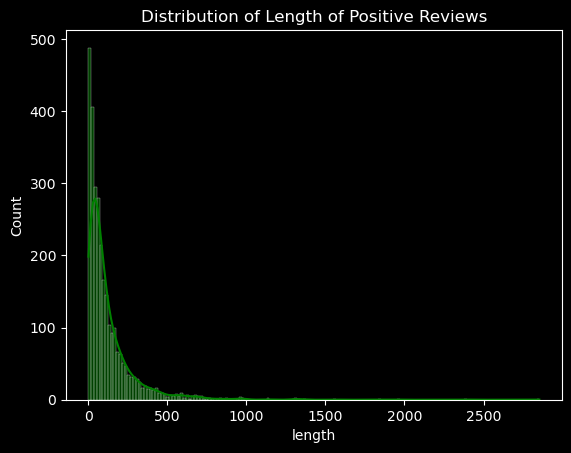

In [33]:
sns.histplot(df[df['feedback'] == 1]['length'], color = 'green', kde = True)
plt.title('Distribution of Length of Positive Reviews')

Text(0.5, 1.0, 'Distribution of Length of Negative Reviews')

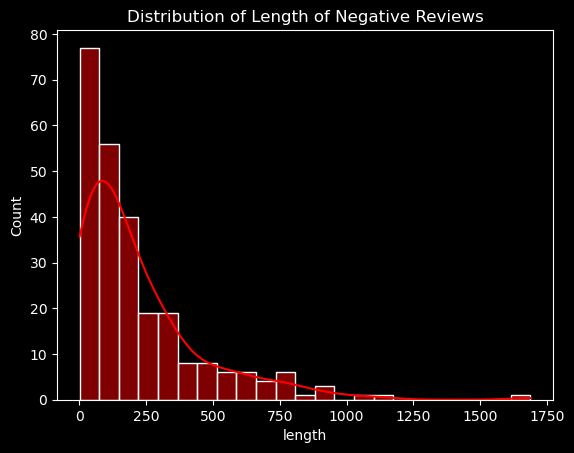

In [34]:
sns.histplot(df[df['feedback']== 0]['length'], color = 'red', kde = True)
plt.title('Distribution of Length of Negative Reviews')


In [35]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df['verified_reviews'])

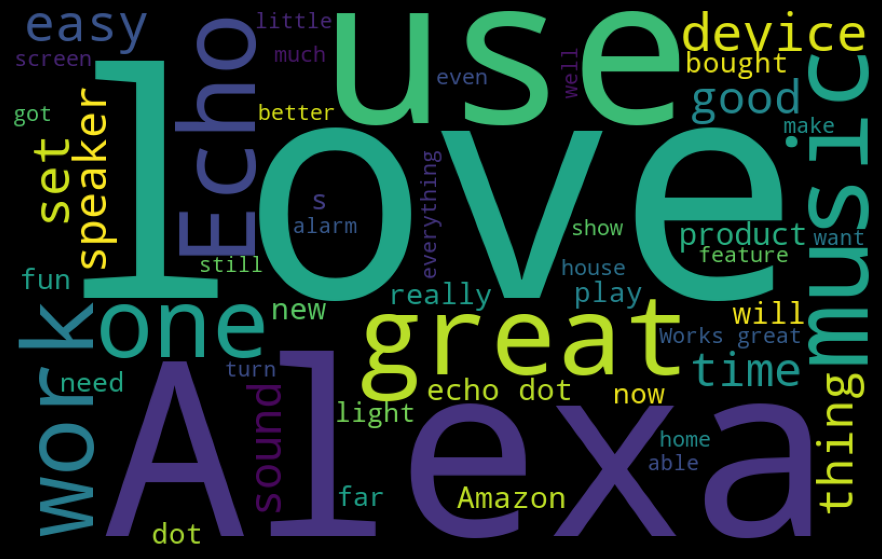

In [36]:
reviews = " ".join([review for review in df['verified_reviews']])
wordcloud = WordCloud(width = 800, height= 500, background_color='black', max_words = 50)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud.generate(reviews))
plt.axis('off')
plt.show()

In [37]:
neg_reviews = " ".join([review for review in df[df['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

poss_reviews = " ".join([review for review in df[df['feedback'] == 1]['verified_reviews']])
poss_reviews = poss_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in poss_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in poss_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


Text(0.5, 1.0, 'WordCloud for negative reviews')

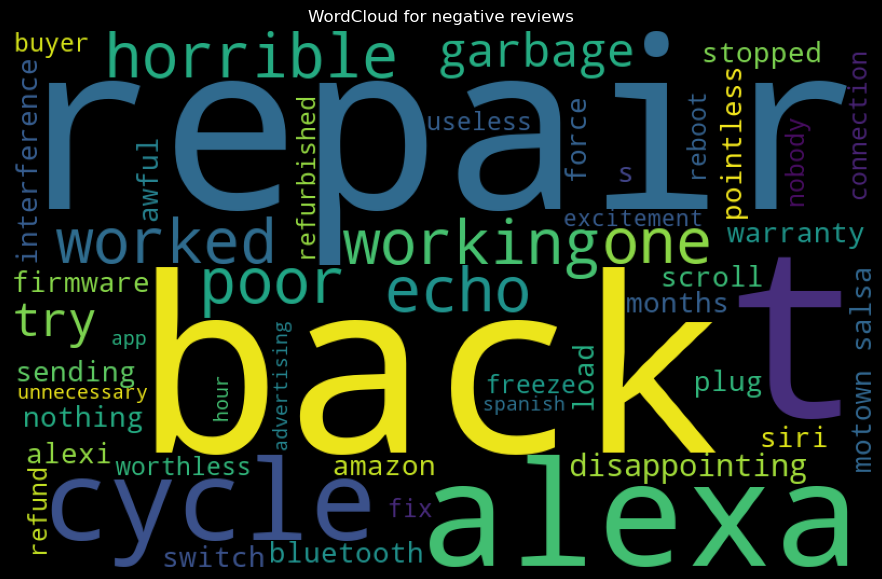

In [38]:
wc = WordCloud(width = 800, height = 500, background_color = 'black', max_words = 50)
plt.figure(figsize =(12, 7))
plt.imshow(wc.generate(unique_negative))
plt.axis('off')
plt.title('WordCloud for negative reviews')

Text(0.5, 1.0, 'WordCloud for positive reviews')

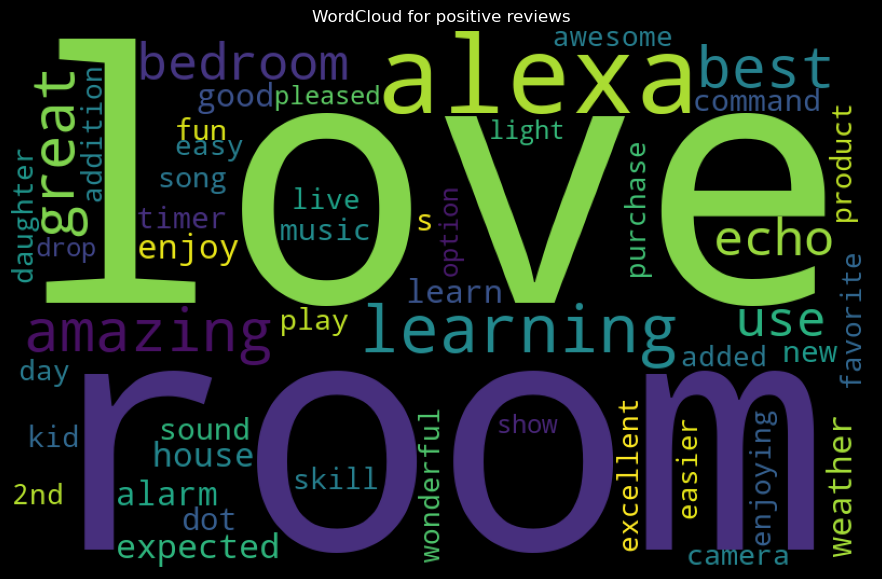

In [39]:
#wordcloud for positive reviews
wc = WordCloud(width = 800, height =500, background_color='black', max_words = 50)
plt.figure(figsize = (12, 7))
plt.imshow(wc.generate(unique_positive))
plt.axis('off')
plt.title('WordCloud for positive reviews')

In [40]:
#Converting all the non alphabetic characters to space
#Converting all the review to the lower case and splitting the words
#iterate over the word and stem the words using the PorterStemmer if not a stop word
corpus = []
stem = PorterStemmer()
for i in range(len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stem.stem(word) for word in review if word not in Stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [41]:
cv = CountVectorizer(max_features=3000)
X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [42]:
#Saving the CountVectorizer object
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [43]:
X.shape


(3149, 2765)

In [44]:
y.shape

(3149,)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)


In [46]:
pd.Series(y).value_counts(normalize=True)


1    0.918704
0    0.081296
Name: proportion, dtype: float64

In [47]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", pd.Series(y_train).value_counts(normalize=True))
print("After SMOTE:", pd.Series(y_train_res).value_counts(normalize=True))

Before SMOTE: 1    0.918784
0    0.081216
Name: proportion, dtype: float64
After SMOTE: 1    0.5
0    0.5
Name: proportion, dtype: float64


In [48]:
X_train_res.max()


12

In [49]:
X_test.max()


8

In [50]:
#Scaling the data to get all the values b/w 0 and 1
scaler = MinMaxScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

In [51]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [52]:
rf = RandomForestClassifier()
rf.fit(X_train_res, y_train_res)

RandomForestClassifier()

In [138]:
print("Train Accuracy: ", rf.score(X_train_res, y_train_res))
print("Test Accuracy: ", rf.score(X_test, y_test))

Train Accuracy:  0.9854320987654321
Test Accuracy:  0.8994708994708994


In [54]:
#Predicting on the test set
y_pred_rf = rf.predict(X_test)

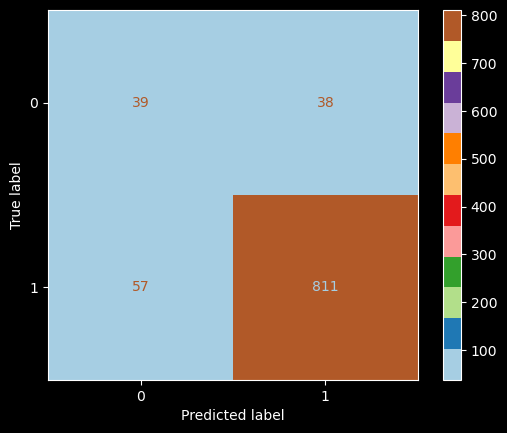

In [55]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf.classes_)
disp.plot(cmap = plt.cm.Paired)

In [56]:
pickle.dump(rf, open('Models/model_rf.pkl', 'wb'))

In [57]:
accuracies = cross_val_score(estimator = rf, X = X_train_res, y = y_train_res, cv = 10)
print("Accuracy from cross-validation: ", accuracies.mean())

Accuracy from cross-validation:  0.9360493827160494


In [58]:
# Applying GridSearchCV to find the best hyperparameters
param = {
    'bootstrap':[True],
    'max_depth':[10, 30],
    'min_samples_split': [2, 10],
    'n_estimators': [100, 300]
    }

In [59]:
cv_type = StratifiedKFold(n_splits = 2)
grid_search = GridSearchCV(estimator = rf, param_grid = param, cv = cv_type, verbose = 0, return_train_score = True)
grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [10, 30],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [60]:
#Best Param combinations
print("Best Parameters: {}".format(grid_search.best_params_))

Best Parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}


In [140]:
best_rf = grid_search.best_estimator_
print("Train Accuracy: ", best_rf.score(X_train_res, y_train_res))
print("Test Accuracy: ", best_rf.score(X_test, y_test))

Train Accuracy:  0.9395061728395062
Test Accuracy:  0.8338624338624339


In [61]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [62]:
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_lambda': [0.1, 1, 10],
    'reg_alpha': [0, 0.1, 1]
}


In [63]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,             # only 20 random combos
    scoring='f1',          # good for imbalanced datasets
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [64]:
random_search.fit(X_train_res, y_train_res)

print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best F1 Score: 0.9095493883948924


In [130]:
best_xgb = random_search.best_estimator_

In [134]:
y_pred_xgb = best_xgb.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.30      0.60      0.40        77
           1       0.96      0.88      0.92       868

    accuracy                           0.86       945
   macro avg       0.63      0.74      0.66       945
weighted avg       0.91      0.86      0.88       945



In [136]:
print("Train Accuracy: ", best_xgb.score(X_train_res, y_train_res))
print("Test Accuracy: ", best_xgb.score(X_test, y_test))

Train Accuracy:  0.9538271604938272
Test Accuracy:  0.855026455026455


In [142]:
cm = confusion_matrix(y_test, y_pred_xgb)
cm

array([[ 46,  31],
       [106, 762]])

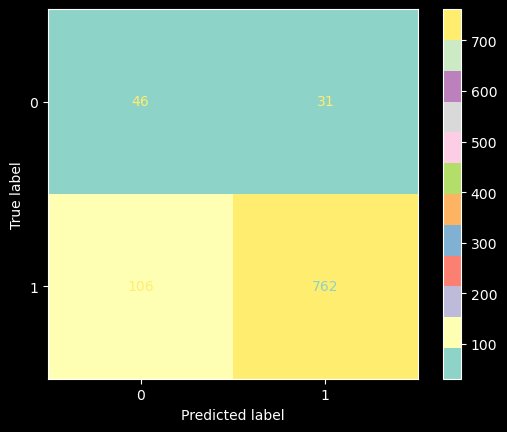

In [144]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_xgb.classes_)
cm_display.plot(cmap = plt.cm.Set3)

In [166]:
with open('Models/model_xgb.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

In [148]:
dt = DecisionTreeClassifier()
dt.fit(X_train_res, y_train_res)

DecisionTreeClassifier()

In [150]:
print("Train_Accuracy_dt", dt.score(X_train_res, y_train_res))
print("Test_Accuracy_dt", dt.score(X_test, y_test))

Train_Accuracy_dt 0.9854320987654321
Test_Accuracy_dt 0.873015873015873


In [152]:
y_pred_dt = dt.predict(X_test)

In [154]:
cm = confusion_matrix(y_test, y_pred_dt)
cm

array([[ 43,  34],
       [ 86, 782]])

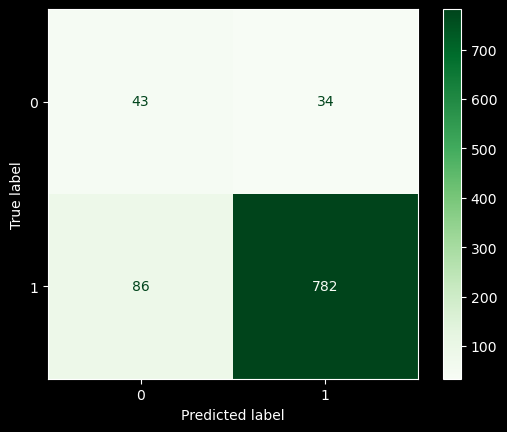

In [158]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = dt.classes_)
cm_display.plot(cmap = 'Greens')

In [160]:
pickle.dump(dt, open('Models/model_dt.pkl', 'wb'))